# Regularization and Evaluation of Neural Networks

In [1]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.confusion import plot_confusion_matrix
    
%load_ext autoreload
%autoreload 2

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [2]:
digits = load_digits()
X = digits.data.astype('float32')
y = digits.target.astype('float32')

y_binary = y % 2

In [3]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 1s 807us/step - loss: 0.9110 - accuracy: 0.6427
Epoch 2/50
180/180 [==============================] - 0s 780us/step - loss: 0.4032 - accuracy: 0.8459
Epoch 3/50
180/180 [==============================] - 0s 767us/step - loss: 0.2712 - accuracy: 0.8971
Epoch 4/50
180/180 [==============================] - 0s 763us/step - loss: 0.2006 - accuracy: 0.9221
Epoch 5/50
180/180 [==============================] - 0s 755us/step - loss: 0.1648 - accuracy: 0.9321
Epoch 6/50
180/180 [==============================] - 0s 764us/step - loss: 0.1378 - accuracy: 0.9527
Epoch 7/50
180/180 [==============================] - 0s 760us/step - loss: 0.1209 - accuracy: 0.9533
Epoch 8/50
180/180 [==============================] - 0s 760us/step - loss: 0.1030 - accuracy: 0.9655
Epoch 9/50
180/180 [==============================] - 0s 749us/step - loss: 0.0959 - accuracy: 0.9605
Epoch 10/50
180/180 [==============================] - 0s 755us/step - loss: 0.079

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling

**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [4]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

### Sigmoid 

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [5]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7399 - accuracy: 0.4961
Epoch 2/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7315 - accuracy: 0.4961
Epoch 3/10
12/12 [==============================] - 0s 911us/step - loss: 0.7245 - accuracy: 0.4961
Epoch 4/10
12/12 [==============================] - 0s 956us/step - loss: 0.7188 - accuracy: 0.4961
Epoch 5/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7139 - accuracy: 0.4961
Epoch 6/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7099 - accuracy: 0.4961
Epoch 7/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7067 - accuracy: 0.4961
Epoch 8/10
12/12 [==============================] - 0s 956us/step - loss: 0.7036 - accuracy: 0.4961
Epoch 9/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7012 - accuracy: 0.4961
Epoch 10/10
12/12 [==============================] - 0s 872us/step - loss: 0.6993 - accuracy: 0.4961


We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [6]:
# dict

results.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x1fba0aeda90>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.7398671507835388,
   0.7315298318862915,
   0.7244662046432495,
   0.7187957167625427,
   0.7139204144477844,
   0.7099419832229614,
   0.7066508531570435,
   0.7036470770835876,
   0.7011765241622925,
   0.699303388595581],
  'accuracy': [0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [7]:
results.history

{'loss': [0.7398671507835388,
  0.7315298318862915,
  0.7244662046432495,
  0.7187957167625427,
  0.7139204144477844,
  0.7099419832229614,
  0.7066508531570435,
  0.7036470770835876,
  0.7011765241622925,
  0.699303388595581],
 'accuracy': [0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434]}

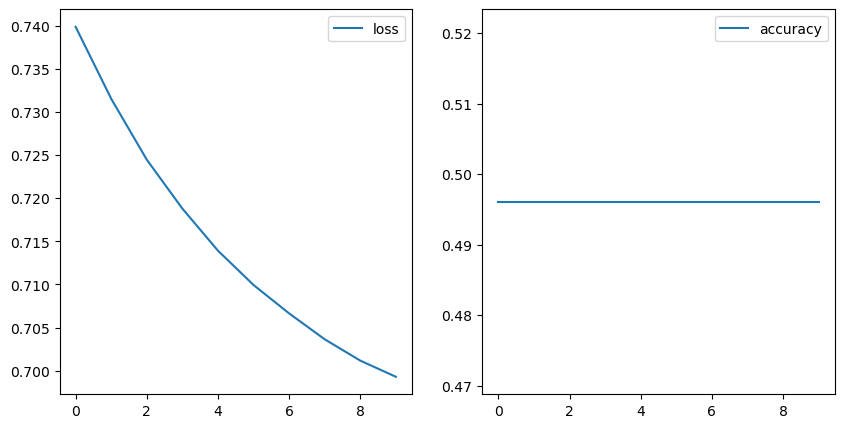

In [8]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

## Basic Model Tuning

### Increase Epochs

In [9]:
model = Sequential()
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs


results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=100, verbose=1)

Epoch 1/100
12/12 [==============================] - 0s 992us/step - loss: 0.9796 - accuracy: 0.4961
Epoch 2/100
12/12 [==============================] - 0s 1ms/step - loss: 0.9331 - accuracy: 0.4961
Epoch 3/100
12/12 [==============================] - 0s 884us/step - loss: 0.8940 - accuracy: 0.4961
Epoch 4/100
12/12 [==============================] - 0s 881us/step - loss: 0.8596 - accuracy: 0.4961
Epoch 5/100
12/12 [==============================] - 0s 984us/step - loss: 0.8320 - accuracy: 0.4961
Epoch 6/100
12/12 [==============================] - 0s 954us/step - loss: 0.8082 - accuracy: 0.4961
Epoch 7/100
12/12 [==============================] - 0s 990us/step - loss: 0.7889 - accuracy: 0.4961
Epoch 8/100
12/12 [==============================] - 0s 947us/step - loss: 0.7724 - accuracy: 0.4961
Epoch 9/100
12/12 [==============================] - 0s 1ms/step - loss: 0.7586 - accuracy: 0.4961
Epoch 10/100
12/12 [==============================] - 0s 1ms/step - loss: 0.7472 - accuracy: 0.

12/12 [==============================] - 0s 910us/step - loss: 0.6931 - accuracy: 0.5448
Epoch 82/100
12/12 [==============================] - 0s 895us/step - loss: 0.6931 - accuracy: 0.5544
Epoch 83/100
12/12 [==============================] - 0s 862us/step - loss: 0.6930 - accuracy: 0.5605
Epoch 84/100
12/12 [==============================] - 0s 963us/step - loss: 0.6930 - accuracy: 0.5535
Epoch 85/100
12/12 [==============================] - 0s 987us/step - loss: 0.6930 - accuracy: 0.5492
Epoch 86/100
12/12 [==============================] - 0s 1ms/step - loss: 0.6930 - accuracy: 0.5396
Epoch 87/100
12/12 [==============================] - 0s 901us/step - loss: 0.6930 - accuracy: 0.5431
Epoch 88/100
12/12 [==============================] - 0s 836us/step - loss: 0.6929 - accuracy: 0.5509
Epoch 89/100
12/12 [==============================] - 0s 885us/step - loss: 0.6929 - accuracy: 0.5544
Epoch 90/100
12/12 [==============================] - 0s 866us/step - loss: 0.6929 - accuracy: 0.

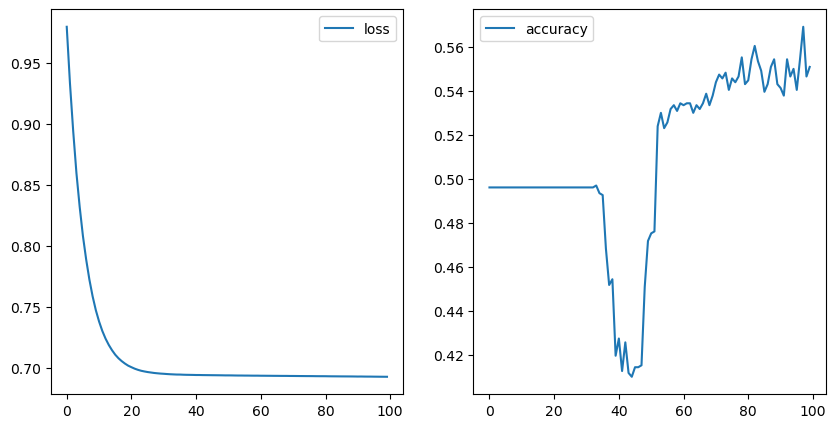

In [10]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Decrease Batch Size

In [14]:
model = Sequential()

model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# decrease batch size

results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=None, verbose=1)

Epoch 1/10
36/36 [==============================] - 0s 787us/step - loss: 0.6917 - accuracy: 0.5727
Epoch 2/10
36/36 [==============================] - 0s 833us/step - loss: 0.6916 - accuracy: 0.6127
Epoch 3/10
36/36 [==============================] - 0s 782us/step - loss: 0.6915 - accuracy: 0.5701
Epoch 4/10
36/36 [==============================] - 0s 836us/step - loss: 0.6914 - accuracy: 0.5648
Epoch 5/10
36/36 [==============================] - 0s 857us/step - loss: 0.6913 - accuracy: 0.5205
Epoch 6/10
36/36 [==============================] - 0s 838us/step - loss: 0.6911 - accuracy: 0.5100
Epoch 7/10
36/36 [==============================] - 0s 777us/step - loss: 0.6911 - accuracy: 0.5753
Epoch 8/10
36/36 [==============================] - 0s 781us/step - loss: 0.6910 - accuracy: 0.5205
Epoch 9/10
36/36 [==============================] - 0s 832us/step - loss: 0.6909 - accuracy: 0.5187
Epoch 10/10
36/36 [==============================] - 0s 808us/step - loss: 0.6908 - accuracy: 0.5039

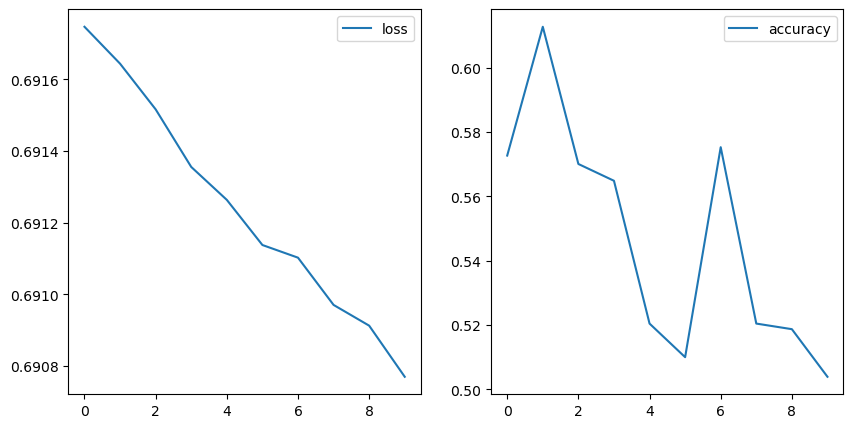

In [15]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Both

In [16]:
model = Sequential()

model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# increase epochs decrease batch size

results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=10, verbose=1)

Epoch 1/100
115/115 [==============================] - 0s 720us/step - loss: 0.6901 - accuracy: 0.5048
Epoch 2/100
115/115 [==============================] - 0s 742us/step - loss: 0.6875 - accuracy: 0.6536
Epoch 3/100
115/115 [==============================] - 0s 735us/step - loss: 0.6863 - accuracy: 0.6501
Epoch 4/100
115/115 [==============================] - 0s 719us/step - loss: 0.6855 - accuracy: 0.6118
Epoch 5/100
115/115 [==============================] - 0s 723us/step - loss: 0.6845 - accuracy: 0.6292
Epoch 6/100
115/115 [==============================] - 0s 735us/step - loss: 0.6837 - accuracy: 0.6971
Epoch 7/100
115/115 [==============================] - 0s 780us/step - loss: 0.6826 - accuracy: 0.7023
Epoch 8/100
115/115 [==============================] - 0s 725us/step - loss: 0.6813 - accuracy: 0.7224
Epoch 9/100
115/115 [==============================] - 0s 732us/step - loss: 0.6802 - accuracy: 0.5875
Epoch 10/100
115/115 [==============================] - 0s 749us/step - l

115/115 [==============================] - 0s 759us/step - loss: 0.2858 - accuracy: 0.8903
Epoch 80/100
115/115 [==============================] - 0s 727us/step - loss: 0.2831 - accuracy: 0.8895
Epoch 81/100
115/115 [==============================] - 0s 732us/step - loss: 0.2805 - accuracy: 0.8869
Epoch 82/100
115/115 [==============================] - 0s 761us/step - loss: 0.2781 - accuracy: 0.8895
Epoch 83/100
115/115 [==============================] - 0s 739us/step - loss: 0.2758 - accuracy: 0.8912
Epoch 84/100
115/115 [==============================] - 0s 747us/step - loss: 0.2732 - accuracy: 0.8886
Epoch 85/100
115/115 [==============================] - 0s 735us/step - loss: 0.2711 - accuracy: 0.8895
Epoch 86/100
115/115 [==============================] - 0s 760us/step - loss: 0.2693 - accuracy: 0.8921
Epoch 87/100
115/115 [==============================] - 0s 749us/step - loss: 0.2668 - accuracy: 0.8930
Epoch 88/100
115/115 [==============================] - 0s 747us/step - loss:

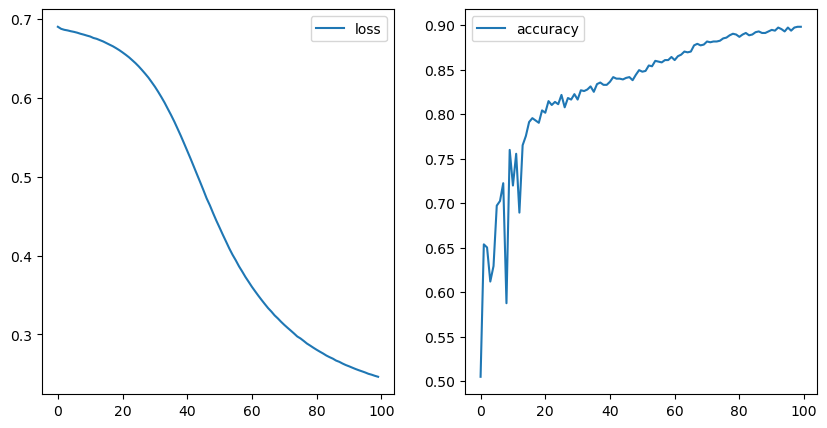

In [17]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Use Relu

In [18]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs, decrease batchsize


results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=10, verbose=1)

Epoch 1/100
115/115 [==============================] - 0s 781us/step - loss: 0.7135 - accuracy: 0.5239
Epoch 2/100
115/115 [==============================] - 0s 748us/step - loss: 0.6719 - accuracy: 0.6876
Epoch 3/100
115/115 [==============================] - 0s 764us/step - loss: 0.6421 - accuracy: 0.7424
Epoch 4/100
115/115 [==============================] - 0s 742us/step - loss: 0.6036 - accuracy: 0.7615
Epoch 5/100
115/115 [==============================] - 0s 734us/step - loss: 0.5552 - accuracy: 0.7824
Epoch 6/100
115/115 [==============================] - 0s 757us/step - loss: 0.4982 - accuracy: 0.8016
Epoch 7/100
115/115 [==============================] - 0s 754us/step - loss: 0.4390 - accuracy: 0.8268
Epoch 8/100
115/115 [==============================] - 0s 755us/step - loss: 0.3893 - accuracy: 0.8486
Epoch 9/100
115/115 [==============================] - 0s 753us/step - loss: 0.3487 - accuracy: 0.8538
Epoch 10/100
115/115 [==============================] - 0s 756us/step - l

115/115 [==============================] - 0s 751us/step - loss: 0.0411 - accuracy: 0.9878
Epoch 80/100
115/115 [==============================] - 0s 764us/step - loss: 0.0388 - accuracy: 0.9930
Epoch 81/100
115/115 [==============================] - 0s 774us/step - loss: 0.0401 - accuracy: 0.9878
Epoch 82/100
115/115 [==============================] - 0s 766us/step - loss: 0.0385 - accuracy: 0.9904
Epoch 83/100
115/115 [==============================] - 0s 772us/step - loss: 0.0364 - accuracy: 0.9922
Epoch 84/100
115/115 [==============================] - 0s 763us/step - loss: 0.0363 - accuracy: 0.9896
Epoch 85/100
115/115 [==============================] - 0s 754us/step - loss: 0.0360 - accuracy: 0.9904
Epoch 86/100
115/115 [==============================] - 0s 759us/step - loss: 0.0341 - accuracy: 0.9939
Epoch 87/100
115/115 [==============================] - 0s 744us/step - loss: 0.0330 - accuracy: 0.9939
Epoch 88/100
115/115 [==============================] - 0s 751us/step - loss:

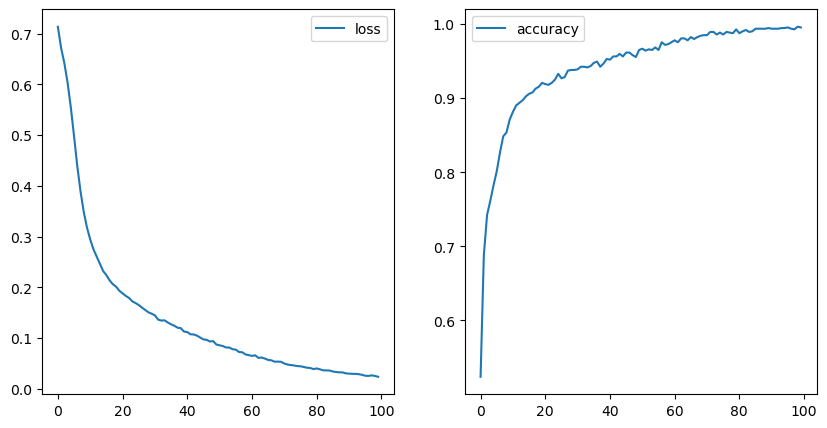

In [19]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### All of it (epochs, batch, relu)

In [20]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs


results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=None, verbose=1)

Epoch 1/100
36/36 [==============================] - 0s 807us/step - loss: 0.6815 - accuracy: 0.5065
Epoch 2/100
36/36 [==============================] - 0s 792us/step - loss: 0.6691 - accuracy: 0.5178
Epoch 3/100
36/36 [==============================] - 0s 743us/step - loss: 0.6587 - accuracy: 0.5370
Epoch 4/100
36/36 [==============================] - 0s 784us/step - loss: 0.6485 - accuracy: 0.5840
Epoch 5/100
36/36 [==============================] - 0s 793us/step - loss: 0.6372 - accuracy: 0.6266
Epoch 6/100
36/36 [==============================] - 0s 787us/step - loss: 0.6250 - accuracy: 0.6701
Epoch 7/100
36/36 [==============================] - 0s 788us/step - loss: 0.6119 - accuracy: 0.6902
Epoch 8/100
36/36 [==============================] - 0s 762us/step - loss: 0.5985 - accuracy: 0.7258
Epoch 9/100
36/36 [==============================] - 0s 752us/step - loss: 0.5849 - accuracy: 0.7459
Epoch 10/100
36/36 [==============================] - 0s 791us/step - loss: 0.5708 - accura

36/36 [==============================] - 0s 758us/step - loss: 0.2220 - accuracy: 0.9104
Epoch 82/100
36/36 [==============================] - 0s 749us/step - loss: 0.2193 - accuracy: 0.9121
Epoch 83/100
36/36 [==============================] - 0s 805us/step - loss: 0.2171 - accuracy: 0.9121
Epoch 84/100
36/36 [==============================] - 0s 810us/step - loss: 0.2155 - accuracy: 0.9130
Epoch 85/100
36/36 [==============================] - 0s 760us/step - loss: 0.2143 - accuracy: 0.9130
Epoch 86/100
36/36 [==============================] - 0s 770us/step - loss: 0.2133 - accuracy: 0.9147
Epoch 87/100
36/36 [==============================] - 0s 763us/step - loss: 0.2102 - accuracy: 0.9173
Epoch 88/100
36/36 [==============================] - 0s 813us/step - loss: 0.2078 - accuracy: 0.9130
Epoch 89/100
36/36 [==============================] - 0s 798us/step - loss: 0.2077 - accuracy: 0.9199
Epoch 90/100
36/36 [==============================] - 0s 810us/step - loss: 0.2051 - accuracy: 

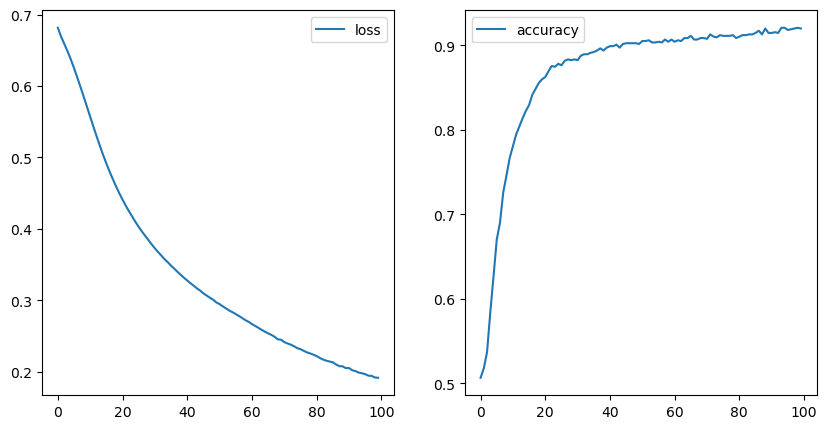

In [21]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Side note: learning rate

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
115/115 [==============================] - 0s 749us/step - loss: 0.5763 - accuracy: 0.7241
Epoch 2/30
115/115 [==============================] - 0s 738us/step - loss: 0.2984 - accuracy: 0.8764
Epoch 3/30
115/115 [==============================] - 0s 747us/step - loss: 0.2295 - accuracy: 0.9025
Epoch 4/30
115/115 [==============================] - 0s 798us/step - loss: 0.1958 - accuracy: 0.9225
Epoch 5/30
115/115 [==============================] - 0s 744us/step - loss: 0.1706 - accuracy: 0.9339
Epoch 6/30
115/115 [==============================] - 0s 775us/step - loss: 0.1389 - accuracy: 0.9504
Epoch 7/30
115/115 [==============================] - 0s 781us/step - loss: 0.1232 - accuracy: 0.9530
Epoch 8/30
115/115 [==============================] - 0s 790us/step - loss: 0.1055 - accuracy: 0.9608
Epoch 9/30
115/115 [==============================] - 0s 736us/step - loss: 0.0832 - accuracy: 0.9730
Epoch 10/30
115/115 [==============================] - 0s 737us/step - loss: 0.072

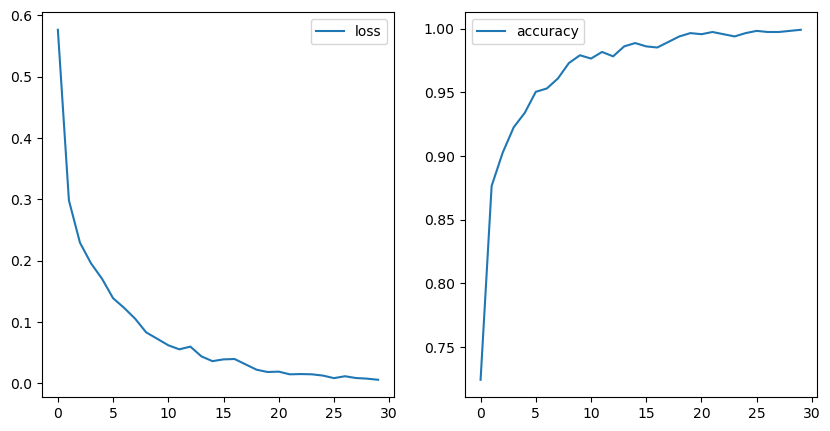

In [25]:
model = Sequential()

sgd = SGD(learning_rate=.09)


model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();


### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Epoch 1/30
115/115 [==============================] - 1s 2ms/step - loss: 0.5614 - accuracy: 0.7668 - val_loss: 0.4602 - val_accuracy: 0.8264
Epoch 2/30
115/115 [==============================] - 0s 1ms/step - loss: 0.3644 - accuracy: 0.8686 - val_loss: 0.3416 - val_accuracy: 0.8646
Epoch 3/30
115/115 [==============================] - 0s 1ms/step - loss: 0.2686 - accuracy: 0.9060 - val_loss: 0.2490 - val_accuracy: 0.9132
Epoch 4/30
115/115 [==============================] - 0s 1ms/step - loss: 0.2210 - accuracy: 0.9182 - val_loss: 0.2042 - val_accuracy: 0.9271
Epoch 5/30
115/115 [==============================] - 0s 1ms/step - loss: 0.1844 - accuracy: 0.9260 - val_loss: 0.1835 - val_accuracy: 0.9236
Epoch 6/30
115/115 [==============================] - 0s 1ms/step - loss: 0.1591 - accuracy: 0.9434 - val_loss: 0.1722 - val_accuracy: 0.9306
Epoch 7/30
115/115 [==============================] - 0s 1ms/step - loss: 0.1409 - accuracy: 0.9460 - val_loss: 0.1529 - val_accuracy: 0.9410
Epoch 

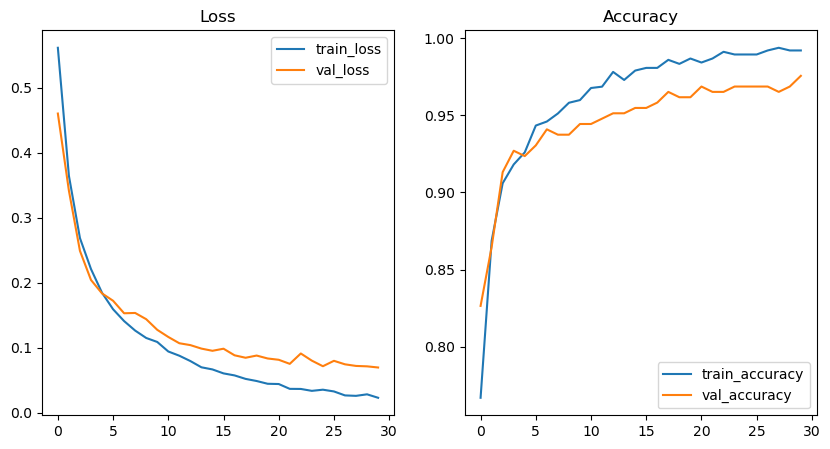

In [26]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE

results = model.fit(
    X_pure_train, y_pure_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=10,
    verbose=1
)


train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [28]:
results.history['val_accuracy'][-1]

0.9756944179534912

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [27]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x000001FBB7E88D90> does not.

In [29]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [32]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=10,
                                          batch_size=32,
                                          verbose=2)

C:\Users\user\AppData\Local\Temp\ipykernel_22160\348061558.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = scikit_learn.KerasClassifier(build_model,


In [33]:
type(keras_model)

keras.wrappers.scikit_learn.KerasClassifier

In [34]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

Epoch 1/10
29/29 - 1s - loss: 0.7291 - accuracy: 0.4973 - 552ms/epoch - 19ms/step
Epoch 2/10
29/29 - 0s - loss: 0.6502 - accuracy: 0.6649 - 24ms/epoch - 833us/step
Epoch 3/10
29/29 - 0s - loss: 0.5898 - accuracy: 0.7878 - 25ms/epoch - 845us/step
Epoch 4/10
29/29 - 0s - loss: 0.5162 - accuracy: 0.8172 - 23ms/epoch - 776us/step
Epoch 5/10
29/29 - 0s - loss: 0.4310 - accuracy: 0.8390 - 22ms/epoch - 756us/step
Epoch 6/10
29/29 - 0s - loss: 0.3652 - accuracy: 0.8553 - 23ms/epoch - 803us/step
Epoch 7/10
29/29 - 0s - loss: 0.3176 - accuracy: 0.8760 - 24ms/epoch - 820us/step
Epoch 8/10
29/29 - 0s - loss: 0.2880 - accuracy: 0.8803 - 23ms/epoch - 795us/step
Epoch 9/10
29/29 - 0s - loss: 0.2670 - accuracy: 0.8825 - 24ms/epoch - 830us/step
Epoch 10/10
29/29 - 0s - loss: 0.2560 - accuracy: 0.8847 - 23ms/epoch - 781us/step
8/8 - 0s - loss: 0.3050 - accuracy: 0.8522 - 94ms/epoch - 12ms/step
Epoch 1/10
29/29 - 1s - loss: 0.6512 - accuracy: 0.6627 - 554ms/epoch - 19ms/step
Epoch 2/10
29/29 - 0s - loss:

array([0.85217392, 0.89565217, 0.9173913 , 0.89999998, 0.86462879])

## [Regularization](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer)

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

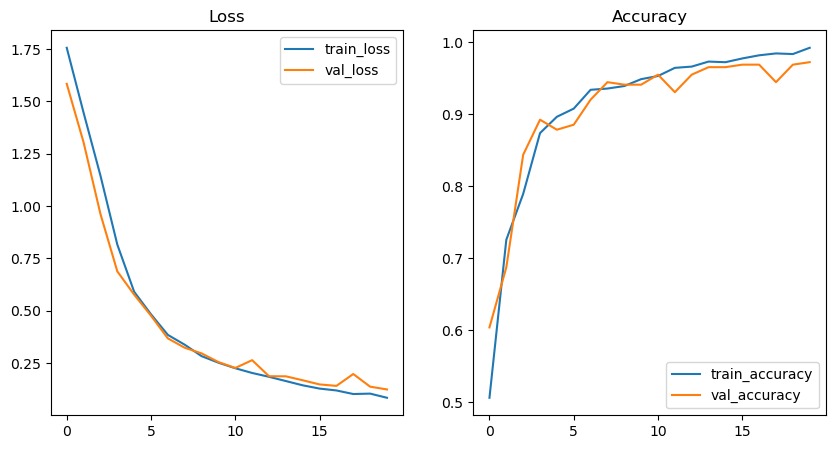

In [35]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',kernel_regularizer=l2(l=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

Adding L2 to multiple layers:

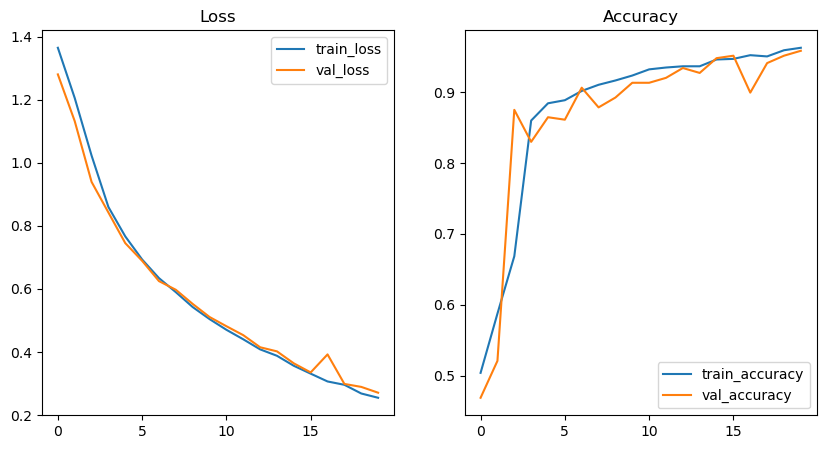

In [36]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

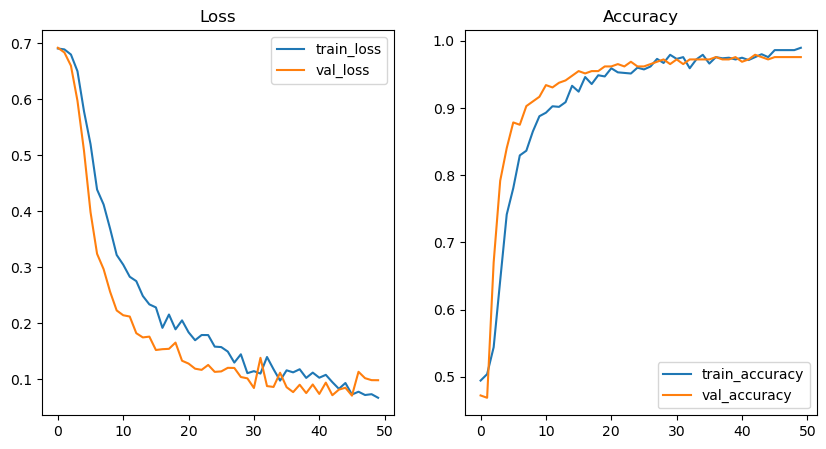

In [39]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [40]:
results.history['val_accuracy'][-1]

0.9756944179534912

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

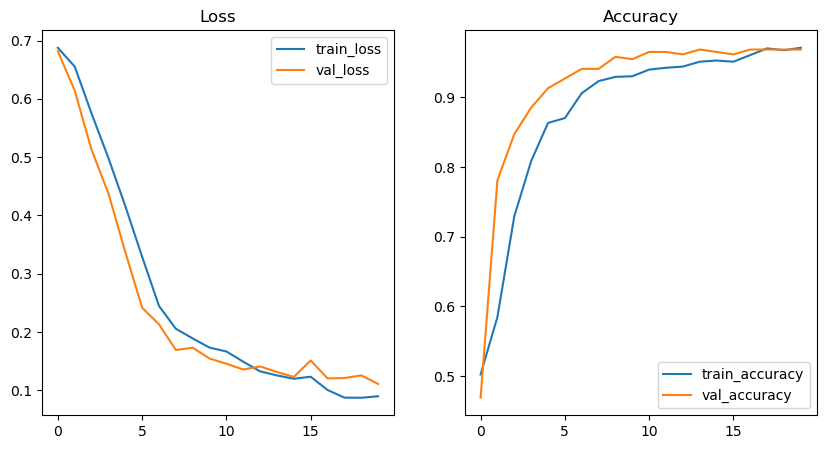

In [46]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=.005,
                           verbose=1,
                           patience=5,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 6: early stopping


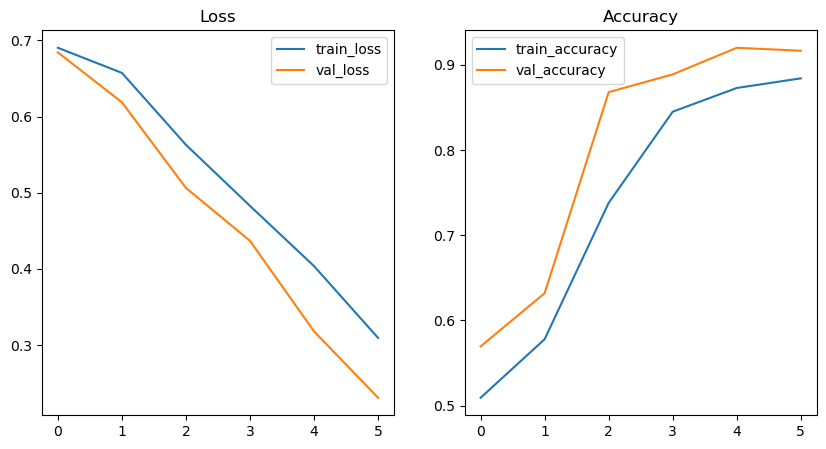

In [48]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=.05,
                           verbose=1,
                           patience=5,
                           mode='min')


# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [49]:
results.history['val_accuracy'][-1]

0.9166666865348816

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [50]:
digits = load_digits()
X = digits.data
y = digits.target

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [52]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [53]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [54]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 1s 2ms/step - loss: 2.2338 - accuracy: 0.1210 - val_loss: 2.1518 - val_accuracy: 0.1667
Epoch 2/50
115/115 [==============================] - 0s 1ms/step - loss: 2.0077 - accuracy: 0.2576 - val_loss: 1.9286 - val_accuracy: 0.2951
Epoch 3/50
115/115 [==============================] - 0s 1ms/step - loss: 1.6928 - accuracy: 0.4682 - val_loss: 1.5621 - val_accuracy: 0.5660
Epoch 4/50
115/115 [==============================] - 0s 1ms/step - loss: 1.3392 - accuracy: 0.6406 - val_loss: 1.2297 - val_accuracy: 0.6736
Epoch 5/50
115/115 [==============================] - 0s 1ms/step - loss: 1.0552 - accuracy: 0.7302 - val_loss: 0.9858 - val_accuracy: 0.8090
Epoch 6/50
115/115 [==============================] - 0s 1ms/step - loss: 0.8304 - accuracy: 0.8059 - val_loss: 0.7724 - val_accuracy: 0.8299
Epoch 7/50
115/115 [==============================] - 0s 1ms/step - loss: 0.6629 - accuracy: 0.8460 - val_loss: 0.6178 - val_accuracy: 0.8646
Epoch 

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [55]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

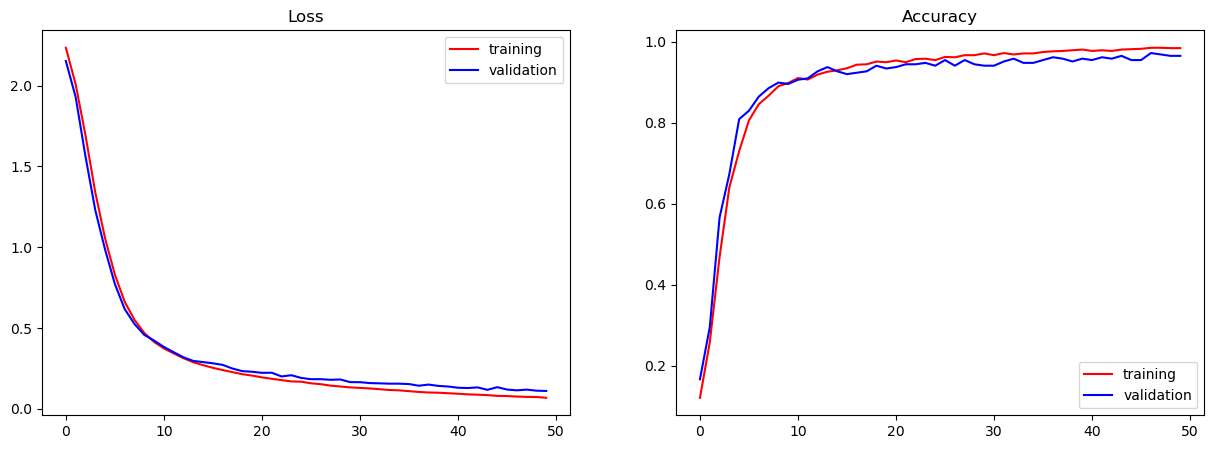

In [56]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)

ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [58]:
np.argmax(model.predict(X_test)[0])

12/12 [==============================] - 0s 645us/step


6

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.
